In [ ]:
# import library
import os, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import chi2_contingency 
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
from statistics import stdev
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
# set figure params (figure size, font size)
plt.rc('figure', figsize=(5, 5))
plt.rc('font', size=13)
plt.style.use('ggplot')

In [ ]:
data=pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [ ]:

fig=make_subplots(rows=1, cols=2, 
                  subplot_titles=("", "Employee Attrition by Work Life Balance"),
                  specs=[[{"type": "bar"}, {"type": "pie"}]])

# Bar chart
plot_df=data['Attrition'].value_counts(normalize=True)
plot_df=plot_df.mul(100).rename('Percent').reset_index().sort_values('Percent')
plot_df.rename(columns={'index':'Attrition'}, inplace=True)
plot_df['Attrition']=['Former Employees' if i == 'Yes' else 'Current Employees' for i in plot_df['Attrition']]
x=plot_df['Attrition']
y=plot_df['Percent']
fig.add_trace(
    go.Bar(x=x, y=y, text=y,opacity=.8,
           hovertemplate='Employee Attrition Rate<br>%{x}: %{y:.3}%<extra></extra>',
           showlegend=False), row=1, col=1)
fig.update_traces(texttemplate='%{text:.3s}%', textposition='outside', 
                  marker_line=dict(width=1, color='#1F0202'), marker_color=['#C02B34','#CDBBA7'])
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='gray')
fig.update_layout(yaxis_ticksuffix = '%')

# Pie chart
plot_df2=data[data.Attrition=='Yes']
plot_df2=plot_df2['WorkLifeBalance'].value_counts(normalize=True)
plot_df2=plot_df2.mul(100).rename('Percent').reset_index().sort_values('Percent', ascending=False)
plot_df2.rename(columns={'index':'WorkLifeBalance'}, inplace=True)
fig.add_trace(go.Pie(labels= ['Poor', 'Neutral', 'Good', 'Excellent'], values=plot_df2['Percent'], opacity=0.85, hole=0.4,
                     hovertemplate='%{label}<br>Attrition Rate: %{value:.3}%<extra></extra>',
                     marker_colors=['#587D65','#ADC4B2','#D1C9C2']), row=1, col=2)
fig.update_yaxes(tickmode = 'array', range=[0, 90], dtick=5)
fig.update_traces(textfont_size=14,textfont_color='black',marker=dict(line=dict(color='#28221D', width=1)))
fig.update_layout(title_text="Employee Attrition Statistics", font_color='#28221D',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')      
fig.show()

In [ ]:
plot_df = data.groupby(['Department', 'Gender'])['MonthlyIncome'].mean()
plot_df = plot_df.mul(12).rename('Salary').reset_index().sort_values('Salary', ascending=False)
fig = px.bar(plot_df, x='Department', y='Salary', color='Gender', text='Salary',  
             barmode='group', opacity=0.75, color_discrete_map={'Female': '#214D5C','Male': '#ACBCC2'})
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside',
                  marker_line=dict(width=1, color='#28221D'))
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='#28221D')
fig.update_layout(title_text='Average Salaries by Department & Gender', font_color='#28221D',
                  yaxis_title='Salary, $', paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



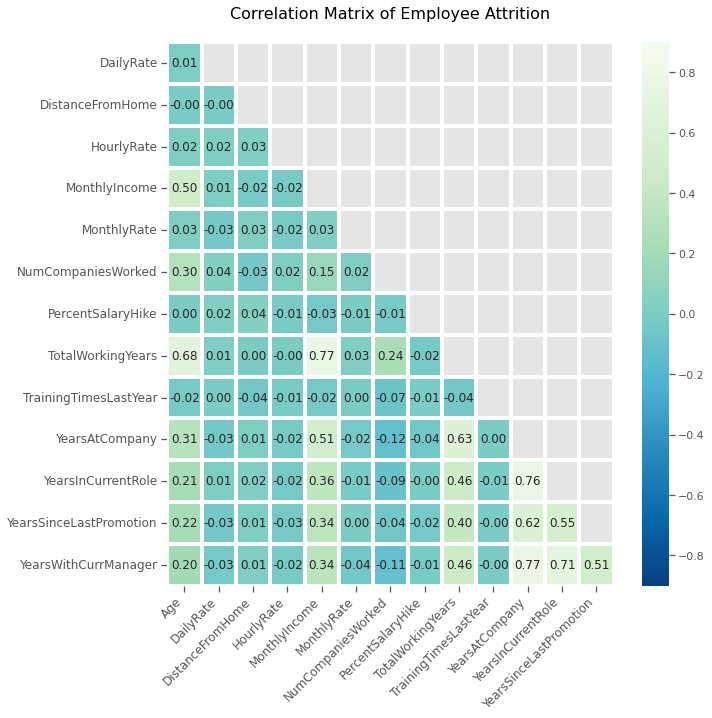

In [ ]:
cat_cols=[]
for i in data.columns:
    if data[i].nunique() <= 5 or data[i].dtype == object:
        cat_cols.append(i)
df=data.copy()
df.drop(df[cat_cols], axis=1, inplace=True)
df.drop('EmployeeNumber', axis=1, inplace=True)

sns.set_context('notebook')
fig, ax = plt.subplots(figsize=(10,10))   
corr=df.corr()
mask=np.triu(np.ones_like(corr, dtype=np.bool))
mask=mask[1:, :-1]
corr=corr.iloc[1:,:-1].copy()
ax=sns.heatmap(corr, mask=mask, vmin=-0.9, center=0, vmax=0.9, annot=True, fmt='.2f', linewidths=3,
               cmap='GnBu_r', annot_kws={"fontsize":12})
ax.set_title('Correlation Matrix of Employee Attrition\n', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
fig.show()

In [ ]:
plot_df = data.copy()
plot_df['JobLevel'] = pd.Categorical(
    plot_df['JobLevel']).rename_categories( #C18183 #px.colors.qualitative.Set3
    ['Entry level', 'Mid level', 'Senior', 'Lead', 'Executive'])
col=['#73AF8E', '#4F909B', '#707BAD', '#A89DB7','#C99193']
fig = px.scatter(plot_df, x='TotalWorkingYears', y='MonthlyIncome', 
                 color='JobLevel', size='MonthlyIncome',
                 color_discrete_sequence=col, 
                 category_orders={'JobLevel': ['Entry level', 'Mid level', 'Senior', 'Lead', 'Executive']})
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                  title='Monthly income increases with total number of years worked and job level <br>',
                  xaxis_title='Total Working Years', yaxis_title='Monthly Income, $', 
                  legend_title='', font_color='#28221D',
                  margin=dict(l=40, r=30, b=80, t=120),paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0')
fig.show()